**We fetch the data**

We select one city to start with

In [233]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
data = pd.read_csv('listings_stockholm.csv.gz', nrows=13815, compression='gzip')

data = data[['accommodates','bedrooms', 'beds', 'review_scores_rating','review_scores_location','review_scores_value','reviews_per_month','property_type','room_type','price']]
data = data[['accommodates','bedrooms','price']]
data = data.dropna()
data.shape


(3667, 3)

**We define a function to change string features to an integer**

In [234]:
def string_features_to_num(array):
    dictOfWords = { i : np.unique(array)[i] for i in range(0, len(np.unique(array)) ) }
    dictOfWords = {v: k for k, v in dictOfWords.items()}

    values = np.zeros(len(array))
    for i in range(len(array)):
        values[i] = dictOfWords.get(array[i])
        
    return values

**Data split into features and target**

We also change the target from a string to a float. 

In [235]:
import re

datanp = np.array(data)
X = datanp[:,:-1]
y = datanp[:,-1]

for i in range(len(y)):
    y[i] = float(re.sub(",", "", (y[i][1:])))

# X[:, -2] = string_features_to_num(X[:, -2])
# X[:, -1] = string_features_to_num(X[:, -1])

**Data split into train/val/test**

In [236]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42)

**Models imported**

In [237]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

linear_model = LinearRegression()
svr_model = SVR(C=60, epsilon=0.95)

**Models fit and scored**

We fit the models on the training set and test with the linear regression. 

In [238]:
linear_model.fit(X_train, y_train)
linear_train_score = linear_model.score(X_train, y_train)
linear_val_score = linear_model.score(X_val,y_val)
linear_test_score = linear_model.score(X_test,y_test)




print(linear_train_score, linear_test_score, linear_val_score)

0.3089322804811102 0.3410922709327532 0.34630907368440056


In [239]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)



In [240]:
from sklearn.svm import NuSVR

svr_model = NuSVR(C=600, nu=0.3)
svr_model.fit(X_train, y_train)
svr_test_score = svr_model.score(X_test, y_test)
print(svr_test_score)

0.2702056881497975


In [241]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=100)
regr.fit(X_train, y_train)

print(regr.score(X_test,y_test))


0.4281140098792079


In [242]:
from sklearn.linear_model import Ridge


clf = Ridge(alpha=5)
clf.fit(X_train, y_train)

print(clf.score(X_test,y_test))

0.3412265749678429


In [243]:
import math
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from sklearn.metrics import r2_score

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

def scale_datasets(x_train, x_test):
    """
    Standard Scale test and train data
    Z - Score normalization
    """
    standard_scaler = StandardScaler()
    x_train_scaled = pd.DataFrame(
        standard_scaler.fit_transform(x_train),
        columns=x_train.columns
    )
    x_test_scaled = pd.DataFrame(
        standard_scaler.transform(x_test),
        columns = x_test.columns
    )
    return x_train_scaled, x_test_scaled
x_train_scaled, x_test_scaled = scale_datasets(X_train, X_test)

In [244]:
hidden_units1 = 160
hidden_units2 = 480
hidden_units3 = 256
learning_rate = 5e-2
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model = Sequential([
    Dense(hidden_units1, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units2, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units3, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])
  return model
# build the model
model = build_model_using_sequential()

In [245]:
# loss function
msle = MeanSquaredLogarithmicError()
model.compile(
    loss=msle, 
    optimizer=Adam(learning_rate=learning_rate), 
    metrics=[msle]
)
# train the model
history = model.fit(
    x_train_scaled.values, 
    np.asarray(y_train.values).astype('float32'), 
    epochs=10, 
    batch_size=10,
    validation_split=0.2
)

Epoch 1/10


2022-11-08 23:37:10.005563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


176/176 [==============================] - 3s 11ms/step - loss: 0.9659 - mean_squared_logarithmic_error: 0.9656 - val_loss: 0.3319 - val_mean_squared_logarithmic_error: 0.3319
Epoch 2/10
  1/176 [..............................] - ETA: 2s - loss: 0.4496 - mean_squared_logarithmic_error: 0.4496

2022-11-08 23:37:12.542305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


176/176 [==============================] - 1s 7ms/step - loss: 0.3510 - mean_squared_logarithmic_error: 0.3510 - val_loss: 0.3153 - val_mean_squared_logarithmic_error: 0.3153
Epoch 3/10
176/176 [==============================] - 1s 6ms/step - loss: 0.3334 - mean_squared_logarithmic_error: 0.3336 - val_loss: 0.3494 - val_mean_squared_logarithmic_error: 0.3494
Epoch 4/10
176/176 [==============================] - 1s 6ms/step - loss: 0.3203 - mean_squared_logarithmic_error: 0.3203 - val_loss: 0.3076 - val_mean_squared_logarithmic_error: 0.3076
Epoch 5/10
176/176 [==============================] - 1s 6ms/step - loss: 0.3409 - mean_squared_logarithmic_error: 0.3408 - val_loss: 0.3568 - val_mean_squared_logarithmic_error: 0.3568
Epoch 6/10
176/176 [==============================] - 1s 7ms/step - loss: 0.3374 - mean_squared_logarithmic_error: 0.3373 - val_loss: 0.3216 - val_mean_squared_logarithmic_error: 0.3216
Epoch 7/10
176/176 [==============================] - 2s 9ms/step - loss: 0.3120 

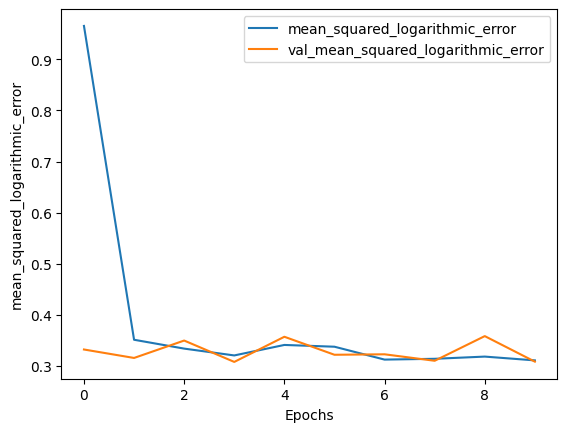

23/23 [==============================] - 0s 2ms/step


2022-11-08 23:37:23.701342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.28134848574341953

In [246]:
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'mean_squared_logarithmic_error')

X_test['prediction'] = model.predict(x_test_scaled)

r2_score(y_test, model.predict(x_test_scaled))
